In [3]:
# Import libraries and modules
import math
import numpy as np
import shutil
import tensorflow as tf
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.15.2-dlenv_tfe
1.18.1


# Local Development

## Arguments

In [16]:
def calc_generator_discriminator_conv_layer_properties(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth):
    """Calculates generator and discriminator conv layer properties.

    Args:
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        kernel_sizes: list, nested list of ints of the kernel sizes for
            each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for both generator and
            discriminator.
    """
    def make_generator(num_filters, kernel_sizes, strides, depth):
        """Calculates generator conv layer properties.

        Args:
            num_filters: list, nested list of ints of the number of filters
                for each conv layer.
            kernel_sizes: list, nested list of ints of the kernel sizes for
                each conv layer.
            strides: list, nested list of ints of the strides for each conv
                layer.
            depth: int, depth dimension of images.

        Returns:
            Nested list of conv layer properties for generator.
        """
        # Get the number of growths.
        num_growths = len(num_filters) - 1

        # Make base block.
        in_out = num_filters[0]
        base = [
            [kernel_sizes[0][i]] * 2 + in_out + [strides[0][i]] * 2
            for i in range(len(num_filters[0]))
        ]
        blocks = [base]

        # Add growth blocks.
        for i in range(1, num_growths + 1):
            in_out = [[blocks[i - 1][-1][-3], num_filters[i][0]]]
            block = [[kernel_sizes[i][0]] * 2 + in_out[0] + [strides[i][0]] * 2]
            for j in range(1, len(num_filters[i])):
                in_out.append([block[-1][-3], num_filters[i][j]])
                block.append(
                    [kernel_sizes[i][j]] * 2 + in_out[j] + [strides[i][j]] * 2
                )
            blocks.append(block)

        # Add toRGB conv.
        blocks[-1].append([1, 1, blocks[-1][-1][-3], depth] + [1] * 2)

        return blocks

    def make_discriminator(generator):
        """Calculates discriminator conv layer properties.

        Args:
            generator: list, nested list of conv layer properties for
                generator.

        Returns:
            Nested list of conv layer properties for discriminator.
        """
        # Reverse generator.
        discriminator = generator[::-1]

        # Reverse input and output shapes.
        discriminator = [
            [
                conv[0:2] + conv[2:4][::-1] + conv[-2:]
                for conv in block[::-1]
            ]
            for block in discriminator
        ]

        return discriminator

    # Calculate conv layer properties for generator using args.
    generator = make_generator(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth
    )

    # Calculate conv layer properties for discriminator using generator
    # properties.
    discriminator = make_discriminator(generator)

    return generator, discriminator


def split_up_generator_conv_layer_properties(
        generator, num_filters, strides, depth):
    """Splits up generator conv layer properties into lists.

    Args:
        generator: list, nested list of conv layer properties for
            generator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for generator.
    """
    generator_base_conv_blocks = [generator[0][0:len(num_filters[0])]]

    generator_growth_conv_blocks = []
    if len(num_filters) > 1:
        generator_growth_conv_blocks = generator[1:-1] + [generator[-1][:-1]]

    generator_to_rgb_layers = [
        [[1] * 2 + [num_filters[i][0]] + [depth] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    return (generator_base_conv_blocks,
            generator_growth_conv_blocks,
            generator_to_rgb_layers)


def split_up_discriminator_conv_layer_properties(
        discriminator, num_filters, strides, depth):
    """Splits up discriminator conv layer properties into lists.

    Args:
        discriminator: list, nested list of conv layer properties for
            discriminator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for discriminator.
    """
    discriminator_from_rgb_layers = [
        [[1] * 2 + [depth] + [num_filters[i][0]] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    if len(num_filters) > 1:
        discriminator_base_conv_blocks = [discriminator[-1]]
    else:
        discriminator_base_conv_blocks = [discriminator[-1][1:]]

    discriminator_growth_conv_blocks = []
    if len(num_filters) > 1:
        discriminator_growth_conv_blocks = [discriminator[0][1:]] + discriminator[1:-1]
        discriminator_growth_conv_blocks = discriminator_growth_conv_blocks[::-1]

    return (discriminator_from_rgb_layers,
            discriminator_base_conv_blocks,
            discriminator_growth_conv_blocks)

In [17]:
# Create arguments dictionary to hold all user passed parameters.
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "data/train.tfrecord"
arguments["eval_file_pattern"] = "data/eval.tfrecord"
arguments["output_dir"] = "local_trained_model"

# Training parameters.
arguments["train_batch_size"] = 32
arguments["train_steps"] = 400

# Eval parameters.
arguments["eval_batch_size"] = 32
arguments["eval_steps"] = 10
arguments["start_delay_secs"] = 600
arguments["throttle_secs"] = 600

# Serving parameters.
arguments["exports_to_keep"] = 20
arguments["predict_all_resolutions"] = True

# Image parameters.
arguments["height"] = 32
arguments["width"] = 32
arguments["depth"] = 3

# Shared parameters.
arguments["num_steps_until_growth"] = 100

# Full lists for full 1024x1024 network growth.
full_conv_num_filters = [[512, 512], [512, 512], [512, 512], [512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
full_conv_kernel_sizes = [[4, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
full_conv_strides = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]

# Set final image size as a multiple of 2, starting at 4.
image_size = 64
prop_list_len = max(
    min(int(math.log(image_size, 2) - 1), len(full_conv_num_filters)), 1
)

# Get slices of lists.
conv_num_filters = full_conv_num_filters[0:prop_list_len]
print("conv_num_filters = {}".format(conv_num_filters))
conv_kernel_sizes = full_conv_kernel_sizes[0:prop_list_len]
print("conv_kernel_sizes = {}".format(conv_kernel_sizes))
conv_strides = full_conv_strides[0:prop_list_len]
print("conv_strides = {}".format(conv_strides))

arguments["conv_num_filters"] = conv_num_filters
arguments["conv_kernel_sizes"] = conv_kernel_sizes
arguments["conv_strides"] = conv_strides

# Truncate lists if over the 1024x1024 current limit.
if len(arguments["conv_num_filters"]) > 9:
    arguments["conv_num_filters"] = arguments["conv_num_filters"][0:10]
    arguments["conv_kernel_sizes"] = arguments["conv_kernel_sizes"][0:10]
    arguments["conv_strides"] = arguments["conv_strides"][0:10]

# Get conv layer properties for generator and discriminator.
(generator,
 discriminator) = calc_generator_discriminator_conv_layer_properties(
    arguments["conv_num_filters"],
    arguments["conv_kernel_sizes"],
    arguments["conv_strides"],
    arguments["depth"]
)

# Split up generator properties into separate lists.
(generator_base_conv_blocks,
 generator_growth_conv_blocks,
 generator_to_rgb_layers) = split_up_generator_conv_layer_properties(
    generator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["generator_base_conv_blocks"] = generator_base_conv_blocks
arguments["generator_growth_conv_blocks"] = generator_growth_conv_blocks
arguments["generator_to_rgb_layers"] = generator_to_rgb_layers

# Split up discriminator properties into separate lists.
(discriminator_from_rgb_layers,
 discriminator_base_conv_blocks,
 discriminator_growth_conv_blocks) = split_up_discriminator_conv_layer_properties(
    discriminator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["discriminator_from_rgb_layers"] = discriminator_from_rgb_layers
arguments["discriminator_base_conv_blocks"] = discriminator_base_conv_blocks
arguments["discriminator_growth_conv_blocks"] = discriminator_growth_conv_blocks

# Generator parameters.
arguments["latent_size"] = 512
arguments["normalize_latent"] = True
arguments["use_pixel_norm"] = True
arguments["pixel_norm_epsilon"] = 1e-8
arguments["generator_projection_dims"] = [4, 4, 512]
arguments["generator_l1_regularization_scale"] = 0.01
arguments["generator_l2_regularization_scale"] = 0.01
arguments["generator_optimizer"] = "GradientDescent"
arguments["generator_learning_rate"] = 0.0001
arguments["generator_clip_gradients"] = 2.0
arguments["generator_train_steps"] = 1

# Discriminator hyperparameters.
arguments["discriminator_l1_regularization_scale"] = 0.01
arguments["discriminator_l2_regularization_scale"] = 0.01
arguments["discriminator_optimizer"] = "GradientDescent"
arguments["discriminator_learning_rate"] = 0.0001
arguments["discriminator_clip_gradients"] = 2.0
arguments["discriminator_gradient_penalty_coefficient"] = 10.0
arguments["discriminator_train_steps"] = 1


conv_num_filters = [[512, 512], [512, 512], [512, 512], [512, 512], [256, 256]]
conv_kernel_sizes = [[4, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
conv_strides = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]


## print_object.py

In [5]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))


## input.py

In [6]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\ndecode_example", "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )
    print_obj("decode_example", "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj("decode_example", "image", image)

    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj("decode_example", "image", image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)
    print_obj("decode_example", "label", label)

    return {"image": image}, label


def read_dataset(filename, mode, batch_size, params):
    """Reads CSV time series data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read CSV dataset
    using Dataset API, apply necessary preprocessing, and return an input
    function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.gfile.Glob(filename=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list, num_parallel_reads=40
        )

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.contrib.data.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=4
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(buffer_size=2)

        # Create a iterator, then get batch of features from example queue.
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn


## generator.py

In [7]:
class Generator(object):
    """
    Fields:
        name: str, name of `Generator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for kernel
            variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        projection_layer: `Dense` layer for projection of noise to image.
        conv_layer_blocks: list, lists of block layers for each block.
        to_rgb_conv_layers: list, toRGB 1x1 conv layers.
        build_generator_tensors: list, tensors used to build layer internals.
    """
    def __init__(self, kernel_regularizer, bias_regularizer, params, name):
        """Creates generator network and returns generated output.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            params: dict, user passed parameters.
            name: str, name of generator.
        """
        # Set name of generator.
        self.name = name

        # Regularizer for kernel weights.
        self.kernel_regularizer = kernel_regularizer

        # Regularizer for bias weights.
        self.bias_regularizer = bias_regularizer

        # Instantiate generator layers.
        (self.projection_layer,
         self.conv_layer_blocks,
         self.to_rgb_conv_layers) = self.instantiate_generator_layers(params)

        # Build generator layer internals.
        self.build_generator_tensors = self.build_generator_layers(
            params
        )

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def instantiate_generator_projection_layer(self, params):
        """Instantiates generator projection layer.

        Projection layer projects latent noise vector into an image.

        Args:
            params: dict, user passed parameters.

        Returns:
            Latent vector projection `Dense` layer.
        """
        # Project latent vectors.
        projection_height = params["generator_projection_dims"][0]
        projection_width = params["generator_projection_dims"][1]
        projection_depth = params["generator_projection_dims"][2]

        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # shape = (
            #     cur_batch_size,
            #     projection_height * projection_width * projection_depth
            # )
            projection_layer = tf.layers.Dense(
                units=projection_height * projection_width * projection_depth,
                activation=tf.nn.leaky_relu,
                kernel_initializer="he_normal",
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                name="{}_projection_layer".format(self.name)
            )
            print_obj(
                "\ninstantiate_generator_projection_layer",
                "projection_layer",
                projection_layer
            )

        return projection_layer

    def instantiate_generator_base_conv_layer_block(self, params):
        """Instantiates generator base conv layer block.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of base block conv layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["generator_base_conv_blocks"][0]

            # Create list of base conv layers.
            base_conv_layers = [
                tf.layers.Conv2D(
                    filters=conv_block[i][3],
                    kernel_size=conv_block[i][0:2],
                    strides=conv_block[i][4:6],
                    padding="same",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                        self.name,
                        i,
                        conv_block[i][0],
                        conv_block[i][1],
                        conv_block[i][2],
                        conv_block[i][3]
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\ninstantiate_generator_base_conv_layer_block",
                "base_conv_layers",
                base_conv_layers
            )

        return base_conv_layers

    def instantiate_generator_growth_layer_block(self, params, block_idx):
        """Instantiates generator growth layer block.

        Args:
            params: dict, user passed parameters.
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block conv layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["generator_growth_conv_blocks"][block_idx]

            # Create new inner convolutional layers.
            conv_layers = [
                tf.layers.Conv2D(
                    filters=conv_block[i][3],
                    kernel_size=conv_block[i][0:2],
                    strides=conv_block[i][4:6],
                    padding="same",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                        self.name,
                        block_idx,
                        i,
                        conv_block[i][0],
                        conv_block[i][1],
                        conv_block[i][2],
                        conv_block[i][3]
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\ninstantiate_generator_growth_layer_block",
                "conv_layers",
                conv_layers
            )

        return conv_layers

    def instantiate_generator_to_rgb_layers(self, params):
        """Instantiates generator toRGB layers of 1x1 convs.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of toRGB 1x1 conv layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get toRGB layer properties.
            to_rgb = [
                params["generator_to_rgb_layers"][i][0][:]
                for i in range(len(params["generator_to_rgb_layers"]))
            ]

            # Create list to hold toRGB 1x1 convs.
            to_rgb_conv_layers = [
                tf.layers.Conv2D(
                    filters=to_rgb[i][3],
                    kernel_size=to_rgb[i][0:2],
                    strides=to_rgb[i][4:6],
                    padding="same",
                    # Notice there is no activation for toRGB conv layers.
                    activation=None,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_to_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                        self.name,
                        i,
                        to_rgb[i][0],
                        to_rgb[i][1],
                        to_rgb[i][2],
                        to_rgb[i][3]
                    )
                )
                for i in range(len(to_rgb))
            ]
            print_obj(
                "\ninstantiate_generator_to_rgb_layers",
                "to_rgb_conv_layers",
                to_rgb_conv_layers
            )

        return to_rgb_conv_layers

    def instantiate_generator_layers(self, params):
        """Instantiates layers of generator network.

        Args:
            params: dict, user passed parameters.

        Returns:
            projection_layer: `Dense` layer for projection of noise to image.
            conv_layer_blocks: list, lists of block layers for each block.
            to_rgb_conv_layers: list, toRGB 1x1 conv layers.
        """
        # Instantiate noise-image projection `Dense` layer.
        projection_layer = self.instantiate_generator_projection_layer(
            params=params
        )
        print_obj(
            "\ninstantiate_generator_layers",
            "projection_layer",
            projection_layer
        )

        # Instantiate base convolutional `Conv2D` layers, for post-growth.
        conv_layer_blocks = [
            self.instantiate_generator_base_conv_layer_block(
                params=params
            )
        ]

        # Instantiate growth block `Conv2D` layers.
        conv_layer_blocks.extend(
            [
                self.instantiate_generator_growth_layer_block(
                    params=params, block_idx=block_idx
                )
                for block_idx in range(
                    len(params["generator_growth_conv_blocks"])
                )
            ]
        )
        print_obj(
            "instantiate_generator_layers",
            "conv_layer_blocks",
            conv_layer_blocks
        )

        # Instantiate toRGB 1x1 `Conv2D` layers.
        to_rgb_conv_layers = self.instantiate_generator_to_rgb_layers(
            params=params
        )
        print_obj(
            "instantiate_generator_layers",
            "to_rgb_conv_layers",
            to_rgb_conv_layers
        )

        return projection_layer, conv_layer_blocks, to_rgb_conv_layers

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def build_generator_projection_layer(self, params):
        """Builds generator projection layer internals using call.

        Args:
            params: dict, user passed parameters.

        Returns:
            Latent vector projection tensor.
        """
        # Project latent vectors.
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # shape = (
            #     cur_batch_size,
            #     projection_height * projection_width * projection_depth
            # )
            projection_tensor = self.projection_layer(
                inputs=tf.zeros(
                    shape=[1, params["latent_size"]], dtype=tf.float32
                )
            )
            print_obj(
                "\nbuild_generator_projection_layer",
                "projection_tensor",
                projection_tensor
            )

        return projection_tensor

    def build_generator_base_conv_layer_block(self, params):
        """Builds generator base conv layer block internals using call.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of base conv tensors.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["generator_base_conv_blocks"][0]

            # Create list of base conv layers.
            base_conv_tensors = [
                # The base conv block is always the 0th one.
                self.conv_layer_blocks[0][i](
                    inputs=tf.zeros(
                        shape=[1] + conv_block[i][0:3], dtype=tf.float32
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\nbuild_generator_base_conv_layer_block",
                "base_conv_tensors",
                base_conv_tensors
            )

        return base_conv_tensors

    def build_generator_growth_layer_block(
            self, params, growth_block_idx):
        """Builds generator growth block internals through call.

        Args:
            params: dict, user passed parameters.
            growth_block_idx: int, the current growth block's index.

        Returns:
            List of growth block tensors.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["generator_growth_conv_blocks"][growth_block_idx]

            # Create new inner convolutional layers.
            conv_tensors = [
                self.conv_layer_blocks[1 + growth_block_idx][i](
                    inputs=tf.zeros(
                        shape=[1] + conv_block[i][0:3], dtype=tf.float32
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\nbuild_generator_growth_layer_block",
                "conv_tensors",
                conv_tensors
            )

        return conv_tensors

    def build_generator_to_rgb_layers(self, params):
        """Builds generator toRGB layers of 1x1 convs internals through call.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of toRGB 1x1 conv tensors.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get toRGB layer properties.
            to_rgb = [
                params["generator_to_rgb_layers"][i][0][:]
                for i in range(len(params["generator_to_rgb_layers"]))
            ]

            # Create list to hold toRGB 1x1 convs.
            to_rgb_conv_tensors = [
                self.to_rgb_conv_layers[i](
                    inputs=tf.zeros(
                        shape=[1] + to_rgb[i][0:3], dtype=tf.float32)
                    )
                for i in range(len(to_rgb))
            ]
            print_obj(
                "\nbuild_generator_to_rgb_layers",
                "to_rgb_conv_tensors",
                to_rgb_conv_tensors
            )

        return to_rgb_conv_tensors

    def build_generator_layers(self, params):
        """Builds generator layer internals.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of toRGB tensors.
        """
        # Build projection layer internals using call.
        projection_tensor = self.build_generator_projection_layer(
            params=params
        )
        print_obj(
            "\nbuild_generator_layers",
            "projection_tensor",
            projection_tensor
        )

        with tf.control_dependencies(control_inputs=[projection_tensor]):
            # Build base convolutional layer block's internals using call.
            conv_block_tensors = [
                self.build_generator_base_conv_layer_block(
                    params=params
                )
            ]

            # Build growth block layer internals through call.
            conv_block_tensors.extend(
                [
                    self.build_generator_growth_layer_block(
                        params=params,
                        growth_block_idx=growth_block_idx
                    )
                    for growth_block_idx in range(
                        len(params["generator_growth_conv_blocks"])
                    )
                ]
            )
            print_obj(
                "build_generator_layers",
                "conv_block_tensors",
                conv_block_tensors
            )

            # Flatten block tensor lists of lists into list.
            conv_block_tensors = [
                item for sublist in conv_block_tensors for item in sublist
            ]
            print_obj(
                "build_generator_layers",
                "conv_block_tensors",
                conv_block_tensors
            )

            with tf.control_dependencies(
                    control_inputs=conv_block_tensors):
                # Build toRGB 1x1 conv layer internals through call.
                to_rgb_conv_tensors = self.build_generator_to_rgb_layers(
                    params=params
                )
                print_obj(
                    "build_generator_layers",
                    "to_rgb_conv_tensors",
                    to_rgb_conv_tensors
                )

        return to_rgb_conv_tensors

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def pixel_norm(self, X, epsilon=1e-8):
        """Normalizes the feature vector in each pixel to unit length.

        Args:
            X: tensor, image feature vectors.
            epsilon: float, small value to add to denominator for numerical
                stability.

        Returns:
            Pixel normalized feature vectors.
        """
        with tf.variable_scope("{}/pixel_norm".format(self.name)):
            return X * tf.rsqrt(
                x=tf.add(
                    x=tf.reduce_mean(
                        input_tensor=tf.square(x=X), axis=1, keepdims=True
                    ),
                    y=epsilon
                )
            )

    def use_pixel_norm(self, X, params, epsilon=1e-8):
        """Decides based on user parameter whether to use pixel norm or not.

        Args:
            X: tensor, image feature vectors.
            params: dict, user passed parameters.
            epsilon: float, small value to add to denominator for numerical
                stability.

        Returns:
            Pixel normalized feature vectors if using pixel norm, else
                original feature vectors.
        """
        if params["use_pixel_norm"]:
            return self.pixel_norm(X=X, epsilon=epsilon)
        else:
            return X

    def use_generator_projection_layer(self, Z, params):
        """Uses projection layer to convert random noise vector into an image.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            params: dict, user passed parameters.

        Returns:
            Latent vector projection tensor.
        """
        # Project latent vectors.
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            if params["normalize_latent"]:
                # shape = (cur_batch_size, latent_size)
                Z = self.pixel_norm(X=Z, epsilon=params["pixel_norm_epsilon"])

            # shape = (
            #     cur_batch_size,
            #     projection_height * projection_width * projection_depth
            # )
            projection_tensor = self.projection_layer(inputs=Z)
            print_obj(
                "\nuse_generator_projection_layer",
                "projection_tensor",
                projection_tensor
            )

        # Reshape projection into "image".
        # shape = (
        #     cur_batch_size,
        #     projection_height,
        #     projection_width,
        #     projection_depth
        # )
        projection_tensor_reshaped = tf.reshape(
            tensor=projection_tensor,
            shape=[-1] + params["generator_projection_dims"],
            name="{}_projection_reshaped".format(self.name)
        )
        print_obj(
            "use_generator_projection_layer",
            "projection_tensor_reshaped",
            projection_tensor_reshaped
        )

        return projection_tensor_reshaped

    def fused_conv2d_pixel_norm(self, input_image, conv2d_layer, params):
        """Fused `Conv2D` layer and pixel norm operation.

        Args:
            input_image: tensor, input image of rank 4.
            conv2d_layer: `Conv2D` layer.
            params: dict, user passed parameters.

        Returns:
            New image tensor of rank 4.
        """
        conv_output = conv2d_layer(inputs=input_image)
        print_obj("\nfused_conv2d_pixel_norm", "conv_output", conv_output)

        pixel_norm_output = self.use_pixel_norm(
            X=conv_output,
            params=params,
            epsilon=params["pixel_norm_epsilon"]
        )
        print_obj(
            "fused_conv2d_pixel_norm", "pixel_norm_output", pixel_norm_output
        )

        return pixel_norm_output

    def upsample_generator_image(self, image, original_image_size, block_idx):
        """Upsamples generator image.

        Args:
            image: tensor, image created by generator conv block.
            original_image_size: list, the height and width dimensions of the
                original image before any growth.
            block_idx: int, index of the current generator growth block.

        Returns:
            Upsampled image tensor.
        """
        # Upsample from s X s to 2s X 2s image.
        upsampled_image = tf.image.resize(
            images=image,
            size=tf.convert_to_tensor(
                value=original_image_size,
                dtype=tf.int32,
                name="{}_upsample_generator_image_original_image_size".format(
                    self.name
                )
            ) * 2 ** block_idx,
            method="nearest",
            name="{}_growth_upsampled_image_{}_{}x{}_{}x{}".format(
                self.name,
                block_idx,
                original_image_size[0] * 2 ** (block_idx - 1),
                original_image_size[1] * 2 ** (block_idx - 1),
                original_image_size[0] * 2 ** block_idx,
                original_image_size[1] * 2 ** block_idx
            )
        )
        print_obj(
            "\nupsample_generator_image",
            "upsampled_image",
            upsampled_image
        )

        return upsampled_image

    def create_base_generator_network(self, Z, params):
        """Creates base generator network.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            projection_layer: `Dense` layer for projection of noise into image.
            to_rgb_conv_layers: list, toRGB 1x1 conv layers.
            blocks: list, lists of block layers for each block.
            params: dict, user passed parameters.

        Returns:
            Final network block conv tensor.
        """
        print_obj("\ncreate_base_generator_network", "Z", Z)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Project latent noise vectors into image.
            projection = self.use_generator_projection_layer(
                Z=Z, params=params
            )
            print_obj(
                "create_base_generator_network", "projection", projection
            )

            # Only need the first block and toRGB conv layer for base network.
            block_layers = self.conv_layer_blocks[0]
            to_rgb_conv_layer = self.to_rgb_conv_layers[0]

            # Pass inputs through layer chain.
            block_conv = projection
            for i in range(0, len(block_layers)):
                block_conv = self.fused_conv2d_pixel_norm(
                    input_image=block_conv,
                    conv2d_layer=block_layers[i],
                    params=params
                )
                print_obj(
                    "create_base_generator_network",
                    "block_conv_{}".format(i),
                    block_conv
                )

            # Convert convolution to RGB image.
            to_rgb_conv = self.fused_conv2d_pixel_norm(
                input_image=block_conv,
                conv2d_layer=to_rgb_conv_layer,
                params=params
            )
            print_obj(
                "create_base_generator_network", "to_rgb_conv", to_rgb_conv
            )

        return to_rgb_conv

    def create_growth_transition_generator_network(
            self, Z, original_image_size, alpha_var, params, trans_idx):
        """Creates growth transition generator network.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            original_image_size: list, the height and width dimensions of the
                original image before any growth.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.
            trans_idx: int, index of current growth transition.

        Returns:
            Weighted sum tensor of growing and shrinking network paths.
        """
        print_obj(
            "\nEntered create_growth_transition_generator_network",
            "trans_idx",
            trans_idx
        )
        print_obj("create_growth_transition_generator_network", "Z", Z)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Project latent noise vectors into image.
            projection = self.use_generator_projection_layer(
                Z=Z, params=params
            )
            print_obj(
                "create_growth_transition_generator_network",
                "projection",
                projection
            )

            # Permanent blocks.
            permanent_blocks = self.conv_layer_blocks[0:trans_idx + 1]

            # Base block doesn't need any upsampling so handle differently.
            base_block_conv_layers = permanent_blocks[0]

            # Pass inputs through layer chain.
            block_conv = projection
            for i in range(0, len(base_block_conv_layers)):
                block_conv = self.fused_conv2d_pixel_norm(
                    input_image=block_conv,
                    conv2d_layer=base_block_conv_layers[i],
                    params=params
                )
                print_obj(
                    "create_growth_transition_generator_network",
                    "base_block_conv_{}_{}".format(trans_idx, i),
                    block_conv
                )

            # Growth blocks require first prev conv layer's image upsampled.
            for i in range(1, len(permanent_blocks)):
                # Upsample previous block's image.
                block_conv = self.upsample_generator_image(
                    image=block_conv,
                    original_image_size=original_image_size,
                    block_idx=i
                )
                print_obj(
                    "create_growth_transition_generator_network",
                    "upsample_generator_image_block_conv_{}_{}".format(
                        trans_idx, i
                    ),
                    block_conv
                )

                block_conv_layers = permanent_blocks[i]
                for j in range(0, len(block_conv_layers)):
                    block_conv = self.fused_conv2d_pixel_norm(
                        input_image=block_conv,
                        conv2d_layer=block_conv_layers[j],
                        params=params
                    )
                    print_obj(
                        "create_growth_transition_generator_network",
                        "block_conv_{}_{}_{}".format(trans_idx, i, j),
                        block_conv
                    )

            # Upsample most recent block conv image for both side chains.
            upsampled_block_conv = self.upsample_generator_image(
                image=block_conv,
                original_image_size=original_image_size,
                block_idx=len(permanent_blocks)
            )
            print_obj(
                "create_growth_transition_generator_network",
                "upsampled_block_conv_{}".format(trans_idx),
                upsampled_block_conv
            )

            # Growing side chain.
            growing_block_layers = self.conv_layer_blocks[trans_idx + 1]
            growing_to_rgb_conv_layer = self.to_rgb_conv_layers[trans_idx + 1]

            # Pass inputs through layer chain.
            block_conv = upsampled_block_conv
            for i in range(0, len(growing_block_layers)):
                block_conv = self.fused_conv2d_pixel_norm(
                    input_image=block_conv,
                    conv2d_layer=growing_block_layers[i],
                    params=params
                )
                print_obj(
                    "create_growth_transition_generator_network",
                    "growing_block_conv_{}_{}".format(trans_idx, i),
                    block_conv
                )

            growing_to_rgb_conv = self.fused_conv2d_pixel_norm(
                input_image=block_conv,
                conv2d_layer=growing_to_rgb_conv_layer,
                params=params
            )
            print_obj(
                "create_growth_transition_generator_network",
                "growing_to_rgb_conv_{}".format(trans_idx),
                growing_to_rgb_conv
            )

            # Shrinking side chain.
            shrinking_to_rgb_conv_layer = self.to_rgb_conv_layers[trans_idx]

            # Pass inputs through layer chain.
            shrinking_to_rgb_conv = self.fused_conv2d_pixel_norm(
                input_image=upsampled_block_conv,
                conv2d_layer=shrinking_to_rgb_conv_layer,
                params=params
            )
            print_obj(
                "create_growth_transition_generator_network",
                "shrinking_to_rgb_conv_{}".format(trans_idx),
                shrinking_to_rgb_conv
            )

            # Weighted sum.
            weighted_sum = tf.add(
                x=growing_to_rgb_conv * alpha_var,
                y=shrinking_to_rgb_conv * (1.0 - alpha_var),
                name="growth_transition_weighted_sum_{}".format(trans_idx)
            )
            print_obj(
                "create_growth_transition_generator_network",
                "weighted_sum_{}".format(trans_idx),
                weighted_sum
            )

        return weighted_sum

    def create_final_generator_network(self, Z, original_image_size, params):
        """Creates final generator network.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            original_image_size: list, the height and width dimensions of the
                original image before any growth.
            params: dict, user passed parameters.

        Returns:
            Final network block conv tensor.
        """
        print_obj("\ncreate_final_generator_network", "Z", Z)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Project latent noise vectors into image.
            projection = self.use_generator_projection_layer(
                Z=Z, params=params
            )
            print_obj(
                "create_final_generator_network", "projection", projection
            )

            # Base block doesn't need any upsampling so handle differently.
            base_block_conv_layers = self.conv_layer_blocks[0]

            # Pass inputs through layer chain.
            block_conv = projection
            for i in range(0, len(base_block_conv_layers)):
                block_conv = self.fused_conv2d_pixel_norm(
                    input_image=block_conv,
                    conv2d_layer=base_block_conv_layers[i],
                    params=params
                )
                print_obj(
                    "create_final_generator_network",
                    "base_block_conv_{}".format(i),
                    block_conv
                )

            # Growth blocks require first prev conv layer's image upsampled.
            for i in range(1, len(self.conv_layer_blocks)):
                # Upsample previous block's image.
                block_conv = self.upsample_generator_image(
                    image=block_conv,
                    original_image_size=original_image_size,
                    block_idx=i
                )
                print_obj(
                    "create_final_generator_network",
                    "upsample_generator_image_block_conv_{}".format(i),
                    block_conv
                )

                block_conv_layers = self.conv_layer_blocks[i]
                for j in range(0, len(block_conv_layers)):
                    block_conv = self.fused_conv2d_pixel_norm(
                        input_image=block_conv,
                        conv2d_layer=block_conv_layers[j],
                        params=params
                    )
                    print_obj(
                        "create_final_generator_network",
                        "block_conv_{}_{}".format(i, j),
                        block_conv
                    )

            # Only need the last toRGB conv layer.
            to_rgb_conv_layer = self.to_rgb_conv_layers[-1]

            # Pass inputs through layer chain.
            to_rgb_conv = self.fused_conv2d_pixel_norm(
                input_image=block_conv,
                conv2d_layer=to_rgb_conv_layer,
                params=params
            )
            print_obj(
                "create_final_generator_network", "to_rgb_conv", to_rgb_conv
            )

        return to_rgb_conv

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def switch_case_generator_outputs(
            self, Z, original_image_size, alpha_var, params, growth_index):
        """Uses switch case to use the correct network to generate images.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            original_image_size: list, the height and width dimensions of the
                original image before any growth.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.
            growth_index: int, current growth stage.

        Returns:
            Generated image output tensor.
        """
        # Switch to case based on number of steps for gen outputs.
        generated_outputs = tf.switch_case(
            branch_index=growth_index,
            branch_fns=[
                # 4x4
                lambda: self.create_base_generator_network(
                    Z=Z, params=params
                ),
                # 8x8
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(0, len(params["conv_num_filters"]) - 2)
                ),
                # 16x16
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(1, len(params["conv_num_filters"]) - 2)
                ),
                # 32x32
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(2, len(params["conv_num_filters"]) - 2)
                ),
                # 64x64
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(3, len(params["conv_num_filters"]) - 2)
                ),
                # 128x128
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(4, len(params["conv_num_filters"]) - 2)
                ),
                # 256x256
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(5, len(params["conv_num_filters"]) - 2)
                ),
                # 512x512
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(6, len(params["conv_num_filters"]) - 2)
                ),
                # 1024x1024
                lambda: self.create_growth_transition_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(7, len(params["conv_num_filters"]) - 2)
                ),
                # 1024x1024
                lambda: self.create_final_generator_network(
                    Z=Z,
                    original_image_size=original_image_size,
                    params=params
                )
            ],
            name="{}_switch_case_generated_outputs".format(self.name)
        )

        return generated_outputs

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def get_train_eval_generator_outputs(self, Z, alpha_var, params):
        """Uses generator network and returns generated output for train/eval.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.

        Returns:
            Generated image output tensor of shape
                [cur_batch_size, image_size, image_size, depth].
        """
        print_obj("\nget_train_eval_generator_outputs", "Z", Z)

        # Get generator's output image tensor.
        train_steps = params["train_steps"]
        num_steps_until_growth = params["num_steps_until_growth"]
        num_stages = train_steps // num_steps_until_growth
        if (num_stages <= 0 or len(params["conv_num_filters"]) == 1):
            print(
                "\nget_train_eval_generator_outputs: NOT GOING TO GROW, SKIP SWITCH CASE!"
            )
            # If never going to grow, no sense using the switch case.
            # 4x4
            generated_outputs = self.create_base_generator_network(
                Z=Z, params=params
            )
        else:
            # Find growth index based on global step and growth frequency.
            growth_index = tf.cast(
                x=tf.floordiv(
                    x=tf.train.get_or_create_global_step(),
                    y=params["num_steps_until_growth"],
                    name="{}_global_step_floordiv".format(self.name)
                ),
                dtype=tf.int32,
                name="{}_growth_index".format(self.name)
            )

            # Switch to case based on number of steps for gen outputs.
            generated_outputs = self.switch_case_generator_outputs(
                Z=Z,
                original_image_size=params["generator_projection_dims"][0:2],
                alpha_var=alpha_var,
                params=params,
                growth_index=growth_index
            )

        print_obj(
            "\nget_train_eval_generator_outputs",
            "generated_outputs",
            generated_outputs
        )

        # Wrap generated outputs in a control dependency for the build
        # generator tensors to ensure generator internals are built.
        with tf.control_dependencies(
                control_inputs=self.build_generator_tensors):
            generated_outputs = tf.identity(
                input=generated_outputs,
                name="{}_generated_outputs_identity".format(self.name)
            )

        return generated_outputs

    def get_predict_generator_outputs(self, Z, params):
        """Uses generator network and returns generated output for predict.

        Args:
            Z: tensor, latent vectors of shape [cur_batch_size, latent_size].
            params: dict, user passed parameters.

        Returns:
            Generated image output tensor of shape
                [cur_batch_size, image_size, image_size, depth].
        """
        print_obj("\nget_predict_generator_outputs", "Z", Z)

        if params["predict_all_resolutions"]:
            generated_outputs = [
                # 4x4
                self.create_base_generator_network(Z=Z, params=params)
            ]

            generated_outputs.extend(
                [
                    # 8x8 through 1024x1024
                    self.create_growth_transition_generator_network(
                        Z=Z,
                        original_image_size=params["generator_projection_dims"][0:2],
                        alpha_var=tf.ones(shape=[], dtype=tf.float32),
                        params=params,
                        trans_idx=i
                    )
                    for i in range(len(params["conv_num_filters"]) - 1)
                ]
            )
        else:
            # 1024x1024
            generated_outputs = self.create_final_generator_network(
                Z=Z,
                original_image_size=params["generator_projection_dims"][0:2],
                params=params
            )
        print_obj(
            "get_predict_generator_outputs",
            "generated_outputs",
            generated_outputs
        )

        return generated_outputs

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def get_generator_loss(self, fake_logits, params):
        """Gets generator loss.

        Args:
            fake_logits: tensor, shape of [cur_batch_size, 1] that came from
                discriminator having processed generator's output image.
            params: dict, user passed parameters.

        Returns:
            Generator's total loss tensor of shape [].
        """
        # Calculate base generator loss.
        generator_loss = -tf.reduce_mean(
            input_tensor=fake_logits,
            name="{}_loss".format(self.name)
        )
        print_obj("\nget_generator_loss", "generator_loss", generator_loss)

        # Get generator regularization losses.
        generator_reg_loss = get_regularization_loss(
            params=params, scope=self.name
        )
        print_obj(
            "get_generator_loss",
            "generator_reg_loss",
            generator_reg_loss
        )

        # Combine losses for total losses.
        generator_total_loss = tf.math.add(
            x=generator_loss,
            y=generator_reg_loss,
            name="{}_total_loss".format(self.name)
        )
        print_obj(
            "get_generator_loss", "generator_total_loss", generator_total_loss
        )

        return generator_total_loss


## discriminator.py

In [8]:
class Discriminator(object):
    """
    Fields:
        name: str, name of `Discriminator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for kernel
            variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        from_rgb_conv_layers: list, fromRGB 1x1 `Conv2D` layers.
        conv_layer_blocks: list, lists of `Conv2D` block layers for each
            block.
        transition_downsample_layers: list, `AveragePooling2D` layers for
            downsampling shrinking transition paths.
        flatten_layer: `Flatten` layer prior to logits layer.
        logits_layer: `Dense` layer for logits.
        build_discriminator_tensors: list, tensors used to build layer
            internals.
    """
    def __init__(self, kernel_regularizer, bias_regularizer, params, name):
        """Creates generator network and returns generated output.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            params: dict, user passed parameters.
            name: str, name of discriminator.
        """
        # Set name of discriminator.
        self.name = name

        # Regularizer for kernel weights.
        self.kernel_regularizer = kernel_regularizer

        # Regularizer for bias weights.
        self.bias_regularizer = bias_regularizer

        # Instantiate discriminator layers.
        (self.from_rgb_conv_layers,
         self.conv_layer_blocks,
         self.transition_downsample_layers,
         self.flatten_layer,
         self.logits_layer) = self.instantiate_discriminator_layers(
            params
        )

        # Build discriminator layer internals.
        self.build_discriminator_tensors = self.build_discriminator_layers(
            params
        )

    def instantiate_discriminator_from_rgb_layers(self, params):
        """Instantiates discriminator fromRGB layers of 1x1 convs.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of fromRGB 1x1 Conv2D layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get fromRGB layer properties.
            from_rgb = [
                params["discriminator_from_rgb_layers"][i][0][:]
                for i in range(len(params["discriminator_from_rgb_layers"]))
            ]

            # Create list to hold toRGB 1x1 convs.
            from_rgb_conv_layers = [
                tf.layers.Conv2D(
                    filters=from_rgb[i][3],
                    kernel_size=from_rgb[i][0:2],
                    strides=from_rgb[i][4:6],
                    padding="same",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_from_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                        self.name,
                        i,
                        from_rgb[i][0],
                        from_rgb[i][1],
                        from_rgb[i][2],
                        from_rgb[i][3]
                    )
                )
                for i in range(len(from_rgb))
            ]
            print_obj(
                "\ninstantiate_discriminator_from_rgb_layers",
                "from_rgb_conv_layers",
                from_rgb_conv_layers
            )

        return from_rgb_conv_layers

    def instantiate_discriminator_base_conv_layer_block(self, params):
        """Instantiates discriminator base conv layer block.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of base conv layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["discriminator_base_conv_blocks"][0]

            # Create list of base conv layers.
            base_conv_layers = [
                tf.layers.Conv2D(
                    filters=conv_block[i][3],
                    kernel_size=conv_block[i][0:2],
                    strides=conv_block[i][4:6],
                    padding="same",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                        self.name,
                        i,
                        conv_block[i][0],
                        conv_block[i][1],
                        conv_block[i][2],
                        conv_block[i][3]
                    )
                )
                for i in range(len(conv_block) - 1)
            ]

            # Have valid padding for layer just before flatten and logits.
            base_conv_layers.append(
                tf.layers.Conv2D(
                    filters=conv_block[-1][3],
                    kernel_size=conv_block[-1][0:2],
                    strides=conv_block[-1][4:6],
                    padding="valid",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                        self.name,
                        len(conv_block) - 1,
                        conv_block[-1][0],
                        conv_block[-1][1],
                        conv_block[-1][2],
                        conv_block[-1][3]
                    )
                )
            )
            print_obj(
                "\ninstantiate_discriminator_base_conv_layer_block",
                "base_conv_layers",
                base_conv_layers
            )

        return base_conv_layers

    def instantiate_discriminator_growth_layer_block(self, params, block_idx):
        """Instantiates discriminator growth block layers.

        Args:
            params: dict, user passed parameters.
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["discriminator_growth_conv_blocks"][block_idx]

            # Create new inner convolutional layers.
            conv_layers = [
                tf.layers.Conv2D(
                    filters=conv_block[i][3],
                    kernel_size=conv_block[i][0:2],
                    strides=conv_block[i][4:6],
                    padding="same",
                    activation=tf.nn.leaky_relu,
                    kernel_initializer="he_normal",
                    kernel_regularizer=self.kernel_regularizer,
                    bias_regularizer=self.bias_regularizer,
                    name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                        self.name,
                        block_idx,
                        i,
                        conv_block[i][0],
                        conv_block[i][1],
                        conv_block[i][2],
                        conv_block[i][3]
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\ninstantiate_discriminator_growth_layer_block",
                "conv_layers",
                conv_layers
            )

            # Down sample from 2s X 2s to s X s image.
            downsampled_image_layer = tf.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                name="{}_growth_downsampled_image_{}".format(
                    self.name,
                    block_idx
                )
            )
            print_obj(
                "instantiate_discriminator_growth_layer_block",
                "downsampled_image_layer",
                downsampled_image_layer
            )

        return conv_layers + [downsampled_image_layer]

    def instantiate_discriminator_growth_transition_downsample_layers(
            self, params):
        """Instantiates discriminator growth transition downsample layers.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of growth transition downsample layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Down sample from 2s X 2s to s X s image.
            downsample_layers = [
                tf.layers.AveragePooling2D(
                    pool_size=(2, 2),
                    strides=(2, 2),
                    name="{}_growth_transition_downsample_layer_{}".format(
                        self.name,
                        layer_idx
                    )
                )
                for layer_idx in range(
                    1 + len(params["discriminator_growth_conv_blocks"])
                )
            ]
            print_obj(
                "\ninstantiate_discriminator_growth_transition_downsample_layers",
                "downsample_layers",
                downsample_layers
            )

        return downsample_layers

    def instantiate_discriminator_logits_layer(self):
        """Instantiates discriminator flatten and logits layers.

        Returns:
            Flatten and logits layers of discriminator.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Flatten layer to ready final block conv tensor for dense layer.
            flatten_layer = tf.layers.Flatten(
                name="{}_flatten_layer".format(self.name)
            )
            print_obj(
                "\ncreate_discriminator_logits_layer",
                "flatten_layer",
                flatten_layer
            )

            # Final linear layer for logits.
            logits_layer = tf.layers.Dense(
                units=1,
                activation=None,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                name="{}_layers_dense_logits".format(self.name)
            )
            print_obj(
                "create_growth_transition_discriminator_network",
                "logits_layer",
                logits_layer
            )

        return flatten_layer, logits_layer

    def instantiate_discriminator_layers(self, params):
        """Instantiates layers of discriminator network.

        Args:
            params: dict, user passed parameters.

        Returns:
            from_rgb_conv_layers: list, fromRGB 1x1 `Conv2D` layers.
            conv_layer_blocks: list, lists of `Conv2D` block layers for each
                block.
            transition_downsample_layers: list, `AveragePooling2D` layers for
                downsampling shrinking transition paths.
            flatten_layer: `Flatten` layer prior to logits layer.
            logits_layer: `Dense` layer for logits.
        """
        # Instantiate fromRGB 1x1 `Conv2D` layers.
        from_rgb_conv_layers = self.instantiate_discriminator_from_rgb_layers(
            params=params
        )
        print_obj(
            "instantiate_discriminator_layers",
            "from_rgb_conv_layers",
            from_rgb_conv_layers
        )

        # Instantiate base conv block's `Conv2D` layers, for post-growth.
        conv_layer_blocks = [
            self.instantiate_discriminator_base_conv_layer_block(
                params=params
            )
        ]

        # Instantiate growth `Conv2D` layer blocks.
        conv_layer_blocks.extend(
            [
                self.instantiate_discriminator_growth_layer_block(
                    params=params,
                    block_idx=block_idx
                )
                for block_idx in range(
                    len(params["discriminator_growth_conv_blocks"])
                )
            ]
        )
        print_obj(
            "instantiate_discriminator_layers",
            "conv_layer_blocks",
            conv_layer_blocks
        )

        # Instantiate transition downsample `AveragePooling2D` layers.
        transition_downsample_layers = (
            self.instantiate_discriminator_growth_transition_downsample_layers(
                params=params
            )
        )
        print_obj(
            "instantiate_discriminator_layers",
            "transition_downsample_layers",
            transition_downsample_layers
        )

        # Instantiate `Flatten` and `Dense` logits layers.
        (flatten_layer,
         logits_layer) = self.instantiate_discriminator_logits_layer()
        print_obj(
            "instantiate_discriminator_layers",
            "flatten_layer",
            flatten_layer
        )
        print_obj(
            "instantiate_discriminator_layers",
            "logits_layer",
            logits_layer
        )

        return (from_rgb_conv_layers,
                conv_layer_blocks,
                transition_downsample_layers,
                flatten_layer,
                logits_layer)

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def build_discriminator_from_rgb_layers(self, params):
        """Creates discriminator fromRGB layers of 1x1 convs.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of tensors from fromRGB 1x1 `Conv2D` layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get fromRGB layer properties.
            from_rgb = [
                params["discriminator_from_rgb_layers"][i][0][:]
                for i in range(len(params["discriminator_from_rgb_layers"]))
            ]

            # Create list to hold fromRGB 1x1 convs.
            from_rgb_conv_tensors = [
                self.from_rgb_conv_layers[i](
                    inputs=tf.zeros(
                        shape=[1] + from_rgb[i][0:3], dtype=tf.float32
                    )
                )
                for i in range(len(from_rgb))
            ]
            print_obj(
                "\nbuild_discriminator_from_rgb_layers",
                "from_rgb_conv_tensors",
                from_rgb_conv_tensors
            )

        return from_rgb_conv_tensors

    def build_discriminator_base_conv_layer_block(self, params):
        """Creates discriminator base conv layer block.

        Args:
            params: dict, user passed parameters.

        Returns:
            List of tensors from base `Conv2D` layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["discriminator_base_conv_blocks"][0]

            # The base conv block is always the 0th one.
            base_conv_layer_block = self.conv_layer_blocks[0]

            # Minibatch stddev comes before first base conv layer,
            # creating 1 extra feature map.
            if params["use_minibatch_stddev"]:
                # Therefore, the number of input channels will be 1 higher
                # for first base conv block.
                num_in_channels = conv_block[0][3] + 1
            else:
                num_in_channels = conv_block[0][3]

            # Get first base conv layer from list.
            first_base_conv_layer = base_conv_layer_block[0]

            # Build first layer with bigger tensor.
            base_conv_tensors = [
                first_base_conv_layer(
                    inputs=tf.zeros(
                        shape=[1] + conv_block[0][0:2] + [num_in_channels],
                        dtype=tf.float32
                    )
                )
            ]

            # Now build the rest of the base conv block layers, store in list.
            base_conv_tensors.extend(
                [
                    base_conv_layer_block[i](
                        inputs=tf.zeros(
                            shape=[1] + conv_block[i][0:3], dtype=tf.float32
                        )
                    )
                    for i in range(1, len(conv_block))
                ]
            )
            print_obj(
                "\nbuild_discriminator_base_conv_layer_block",
                "base_conv_tensors",
                base_conv_tensors
            )

        return base_conv_tensors

    def build_discriminator_growth_layer_block(self, params, block_idx):
        """Creates discriminator growth block.

        Args:
            params: dict, user passed parameters.
            block_idx: int, the current growth block's index.

        Returns:
            List of tensors from growth block `Conv2D` layers.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Get conv block layer properties.
            conv_block = params["discriminator_growth_conv_blocks"][block_idx]

            # Create new inner convolutional layers.
            conv_tensors = [
                self.conv_layer_blocks[1 + block_idx][i](
                    inputs=tf.zeros(
                        shape=[1] + conv_block[i][0:3], dtype=tf.float32
                    )
                )
                for i in range(len(conv_block))
            ]
            print_obj(
                "\nbuild_discriminator_growth_layer_block",
                "conv_tensors",
                conv_tensors
            )

        return conv_tensors

    def build_discriminator_logits_layer(self, params):
        """Builds flatten and logits layer internals using call.

        Args:
            params: dict, user passed parameters.

        Returns:
            Final logits tensor of discriminator.
        """
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            block_conv_size = params["discriminator_base_conv_blocks"][-1][-1][3]

            # Flatten final block conv tensor.
            block_conv_flat = self.flatten_layer(
                inputs=tf.zeros(
                    shape=[1, 1, 1, block_conv_size],
                    dtype=tf.float32
                )
            )
            print_obj(
                "\nbuild_discriminator_logits_layer",
                "block_conv_flat",
                block_conv_flat
            )

            # Final linear layer for logits.
            logits = self.logits_layer(inputs=block_conv_flat)
            print_obj("build_discriminator_logits_layer", "logits", logits)

        return logits

    def build_discriminator_layers(self, params):
        """Builds discriminator layer internals.

        Args:
            params: dict, user passed parameters.

        Returns:
            Logits tensor.
        """
        # Build fromRGB 1x1 `Conv2D` layers internals through call.
        from_rgb_conv_tensors = self.build_discriminator_from_rgb_layers(
            params=params
        )
        print_obj(
            "\nbuild_discriminator_layers",
            "from_rgb_conv_tensors",
            from_rgb_conv_tensors
        )

        with tf.control_dependencies(control_inputs=from_rgb_conv_tensors):
            # Create base convolutional block's layer internals using call.
            conv_block_tensors = [
                self.build_discriminator_base_conv_layer_block(
                    params=params
                )
            ]

            # Build growth `Conv2D` layer block internals through call.
            conv_block_tensors.extend(
                [
                    self.build_discriminator_growth_layer_block(
                        params=params, block_idx=block_idx
                    )
                    for block_idx in range(
                       len(params["discriminator_growth_conv_blocks"])
                    )
                ]
            )

            # Flatten conv block tensor lists of lists into list.
            conv_block_tensors = [
                item for sublist in conv_block_tensors for item in sublist
            ]
            print_obj(
                "build_discriminator_layers",
                "conv_block_tensors",
                conv_block_tensors
            )

            with tf.control_dependencies(control_inputs=conv_block_tensors):
                # Build logits layer internals using call.
                logits_tensor = self.build_discriminator_logits_layer(
                    params=params
                )
                print_obj(
                    "build_discriminator_layers",
                    "logits_tensor",
                    logits_tensor
                )

        return logits_tensor

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def minibatch_stddev_common(
            self,
            variance,
            tile_multiples,
            params,
            caller):
        """Adds minibatch stddev feature map to image using grouping.

        This is the code that is common between the grouped and ungroup
        minibatch stddev functions.

        Args:
            variance: tensor, variance of minibatch or minibatch groups.
            tile_multiples: list, length 4, used to tile input to final shape
                input_dims[i] * mutliples[i].
            params: dict, user passed parameters.
            caller: str, name of the calling function.

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [cur_batch_size, image_size, image_size, 1].
        """
        with tf.variable_scope(
                "{}/{}_minibatch_stddev".format(self.name, caller)):
            # Calculate standard deviation over the group plus small epsilon.
            # shape = (
            #     {"grouped": cur_batch_size / group_size, "ungrouped": 1},
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            stddev = tf.sqrt(
                x=variance + 1e-8, name="{}_stddev".format(caller)
            )
            print_obj(
                "minibatch_stddev_common", "{}_stddev".format(caller), stddev
            )

            # Take average over feature maps and pixels.
            if params["minibatch_stddev_averaging"]:
                # grouped shape = (cur_batch_size / group_size, 1, 1, 1)
                # ungrouped shape = (1, 1, 1, 1)
                stddev = tf.reduce_mean(
                    input_tensor=stddev,
                    axis=[1, 2, 3],
                    keepdims=True,
                    name="{}_stddev_average".format(caller)
                )
                print_obj(
                    "minibatch_stddev_common",
                    "{}_stddev_average".format(caller),
                    stddev
                )

            # Replicate over group and pixels.
            # shape = (
            #     cur_batch_size,
            #     image_size,
            #     image_size,
            #     1
            # )
            stddev_feature_map = tf.tile(
                input=stddev,
                multiples=tile_multiples,
                name="{}_stddev_feature_map".format(caller)
            )
            print_obj(
                "minibatch_stddev_common",
                "{}_stddev_feature_map".format(caller),
                stddev_feature_map
            )

        return stddev_feature_map

    def grouped_minibatch_stddev(
            self,
            X,
            cur_batch_size,
            static_image_shape,
            params,
            group_size):
        """Adds minibatch stddev feature map to image using grouping.

        Args:
            X: tf.float32 tensor, image of shape
                [cur_batch_size, image_size, image_size, num_channels].
            cur_batch_size: tf.int64 tensor, the dynamic batch size (in case
                of partial batch).
            static_image_shape: list, the static shape of each image.
            params: dict, user passed parameters.
            group_size: int, size of image groups.

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [cur_batch_size, image_size, image_size, 1].
        """
        with tf.variable_scope(
                "{}/grouped_minibatch_stddev".format(self.name)):
            # The group size should be less than or equal to the batch size.
            # shape = ()
            group_size = tf.minimum(
                x=group_size, y=cur_batch_size, name="group_size"
            )
            print_obj("grouped_minibatch_stddev", "group_size", group_size)

            # Split minibatch into M groups of size group_size, rank 5 tensor.
            # shape = (
            #     group_size,
            #     cur_batch_size / group_size,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            grouped_image = tf.reshape(
                tensor=X,
                shape=[group_size, -1] + static_image_shape,
                name="grouped_image"
            )
            print_obj(
                "grouped_minibatch_stddev",
                "grouped_image",
                grouped_image
            )

            # Find the mean of each group.
            # shape = (
            #     1,
            #     cur_batch_size / group_size,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            grouped_mean = tf.reduce_mean(
                input_tensor=grouped_image,
                axis=0,
                keepdims=True,
                name="grouped_mean"
            )
            print_obj(
                "grouped_minibatch_stddev", "grouped_mean", grouped_mean
            )

            # Center each group using the mean.
            # shape = (
            #     group_size,
            #     cur_batch_size / group_size,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            centered_grouped_image = tf.subtract(
                x=grouped_image, y=grouped_mean, name="centered_grouped_image"
            )
            print_obj(
                "grouped_minibatch_stddev",
                "centered_grouped_image",
                centered_grouped_image
            )

            # Calculate variance over group.
            # shape = (
            #     cur_batch_size / group_size,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            grouped_variance = tf.reduce_mean(
                input_tensor=tf.square(x=centered_grouped_image),
                axis=0,
                name="grouped_variance"
            )
            print_obj(
                "grouped_minibatch_stddev",
                "grouped_variance",
                grouped_variance
            )

            # Get stddev image using ops common to both grouped & ungrouped.
            stddev_feature_map = self.minibatch_stddev_common(
                variance=grouped_variance,
                tile_multiples=[group_size] + static_image_shape[0:2] + [1],
                params=params,
                caller="grouped"
            )
            print_obj(
                "grouped_minibatch_stddev",
                "stddev_feature_map",
                stddev_feature_map
            )

        return stddev_feature_map

    def ungrouped_minibatch_stddev(
            self,
            X,
            cur_batch_size,
            static_image_shape,
            params):
        """Adds minibatch stddev feature map added to image channels.

        Args:
            X: tensor, image of shape
                [cur_batch_size, image_size, image_size, num_channels].
            cur_batch_size: tf.int64 tensor, the dynamic batch size (in case
                of partial batch).
            static_image_shape: list, the static shape of each image.
            params: dict, user passed parameters.

        Returns:
            Minibatch standard deviation feature map image added to
                channels of shape
                [cur_batch_size, image_size, image_size, 1].
        """
        with tf.variable_scope(
                "{}/ungrouped_minibatch_stddev".format(self.name)):
            # Find the mean of each group.
            # shape = (
            #     1,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            mean = tf.reduce_mean(
                input_tensor=X, axis=0, keepdims=True, name="mean"
            )
            print_obj("ungrouped_minibatch_stddev", "mean", mean)

            # Center each group using the mean.
            # shape = (
            #     cur_batch_size,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            centered_image = tf.subtract(
                x=X, y=mean, name="centered_image"
            )
            print_obj(
                "ungrouped_minibatch_stddev",
                "centered_image",
                centered_image
            )

            # Calculate variance over group.
            # shape = (
            #     1,
            #     image_size,
            #     image_size,
            #     num_channels
            # )
            variance = tf.reduce_mean(
                input_tensor=tf.square(x=centered_image),
                axis=0,
                keepdims=True,
                name="variance"
            )
            print_obj(
                "ungrouped_minibatch_stddev",
                "variance",
                variance
            )

            # Get stddev image using ops common to both grouped & ungrouped.
            stddev_feature_map = self.minibatch_stddev_common(
                variance=variance,
                tile_multiples=[cur_batch_size] + static_image_shape[0:2] + [1],
                params=params,
                caller="ungrouped"
            )
            print_obj(
                "ungrouped_minibatch_stddev",
                "stddev_feature_map",
                stddev_feature_map
            )

        return stddev_feature_map

    def minibatch_stddev(self, X, params, group_size=4):
        """Adds minibatch stddev feature map added to image.

        Args:
            X: tensor, image of shape
                [cur_batch_size, image_size, image_size, num_channels].
            params: dict, user passed parameters.
            group_size: int, size of image groups.

        Returns:
            Image with minibatch standard deviation feature map added to
                channels of shape
                [cur_batch_size, image_size, image_size, num_channels + 1].
        """
        with tf.variable_scope("{}/minibatch_stddev".format(self.name)):
            # Get dynamic shape of image.
            # shape = (4,)
            dynamic_image_shape = tf.shape(
                input=X, name="dynamic_image_shape"
            )
            print_obj(
                "\nminibatch_stddev",
                "dynamic_image_shape",
                dynamic_image_shape
            )

            # Extract current batch size (in case this is a partial batch).
            cur_batch_size = dynamic_image_shape[0]

            # Get static shape of image.
            # shape = (3,)
            static_image_shape = params["generator_projection_dims"]
            print_obj(
                "minibatch_stddev", "static_image_shape", static_image_shape
            )

            # cur_batch_size must be divisible by or smaller than group_size.
            divisbility_condition = tf.equal(
                x=tf.mod(x=cur_batch_size, y=group_size),
                y=0,
                name="divisbility_condition"
            )

            less_than_condition = tf.less(
                x=cur_batch_size, y=group_size, name="less_than_condition"
            )

            any_condition = tf.reduce_any(
                input_tensor=[divisbility_condition, less_than_condition],
                name="any_condition"
            )

            # Get minibatch stddev feature map image from grouped or
            # ungrouped branch.
            stddev_feature_map = tf.cond(
                pred=any_condition,
                true_fn=lambda: self.grouped_minibatch_stddev(
                    X=X,
                    cur_batch_size=cur_batch_size,
                    static_image_shape=static_image_shape,
                    params=params,
                    group_size=group_size
                ),
                false_fn=lambda: self.ungrouped_minibatch_stddev(
                    X=X,
                    cur_batch_size=cur_batch_size,
                    static_image_shape=static_image_shape,
                    params=params
                ),
                name="stddev_feature_map_cond"
            )

            # Append to image as new feature map.
            # shape = (
            #     cur_batch_size,
            #     image_size,
            #     image_size,
            #     num_channels + 1
            # )
            appended_image = tf.concat(
                values=[X, stddev_feature_map],
                axis=-1,
                name="appended_image"
            )
            print_obj(
                "minibatch_stddev_common",
                "appended_image",
                appended_image
            )

        return appended_image

    def use_discriminator_logits_layer(self, block_conv, params):
        """Uses flatten and logits layers to get logits tensor.

        Args:
            block_conv: tensor, output of last conv layer of discriminator.
            flatten_layer: `Flatten` layer.
            logits_layer: `Dense` layer for logits.
            params: dict, user passed parameters.

        Returns:
            Final logits tensor of discriminator.
        """
        print_obj(
            "\nuse_discriminator_logits_layer", "block_conv", block_conv
        )
        # Set shape to remove ambiguity for dense layer.
        block_conv.set_shape(
            [
                block_conv.get_shape()[0],
                params["generator_projection_dims"][0] / 4,
                params["generator_projection_dims"][1] / 4,
                block_conv.get_shape()[-1]]
        )
        print_obj("use_discriminator_logits_layer", "block_conv", block_conv)

        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Flatten final block conv tensor.
            block_conv_flat = self.flatten_layer(inputs=block_conv)
            print_obj(
                "use_discriminator_logits_layer",
                "block_conv_flat",
                block_conv_flat
            )

            # Final linear layer for logits.
            logits = self.logits_layer(inputs=block_conv_flat)
            print_obj("use_discriminator_logits_layer", "logits", logits)

        return logits

    def create_base_discriminator_network(self, X, params):
        """Creates base discriminator network.

        Args:
            X: tensor, input image to discriminator.
            params: dict, user passed parameters.

        Returns:
            Final logits tensor of discriminator.
        """
        print_obj("\ncreate_base_discriminator_network", "X", X)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Only need the first fromRGB conv layer & block for base network.
            from_rgb_conv_layer = self.from_rgb_conv_layers[0]
            block_layers = self.conv_layer_blocks[0]

            # Pass inputs through layer chain.
            from_rgb_conv = from_rgb_conv_layer(inputs=X)
            print_obj(
                "create_base_discriminator_network",
                "from_rgb_conv",
                from_rgb_conv
            )

            if params["use_minibatch_stddev"]:
                block_conv = self.minibatch_stddev(
                    X=from_rgb_conv,
                    params=params,
                    group_size=params["minibatch_stddev_group_size"]
                )
            else:
                block_conv = from_rgb_conv

            for i in range(len(block_layers)):
                block_conv = block_layers[i](inputs=block_conv)
                print_obj(
                    "create_base_discriminator_network",
                    "block_conv",
                    block_conv
                )

            # Get logits now.
            logits = self.use_discriminator_logits_layer(
                block_conv=block_conv,
                params=params
            )
            print_obj("create_base_discriminator_network", "logits", logits)

        return logits

    def create_growth_transition_discriminator_network(
            self, X, alpha_var, params, trans_idx):
        """Creates growth transition discriminator network.

        Args:
            X: tensor, input image to discriminator.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.
            trans_idx: int, index of current growth transition.

        Returns:
            Final logits tensor of discriminator.
        """
        print_obj(
            "\nEntered create_growth_transition_discriminator_network",
            "trans_idx",
            trans_idx
        )
        print_obj("create_growth_transition_discriminator_network", "X", X)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Growing side chain.
            growing_from_rgb_conv_layer = self.from_rgb_conv_layers[trans_idx + 1]
            growing_block_layers = self.conv_layer_blocks[trans_idx + 1]

            # Pass inputs through layer chain.
            growing_block_conv = growing_from_rgb_conv_layer(inputs=X)
            print_obj(
                "\ncreate_growth_transition_discriminator_network",
                "growing_block_conv",
                growing_block_conv
            )
            for i in range(len(growing_block_layers)):
                growing_block_conv = growing_block_layers[i](
                    inputs=growing_block_conv
                )
                print_obj(
                    "create_growth_transition_discriminator_network",
                    "growing_block_conv",
                    growing_block_conv
                )

            # Shrinking side chain.
            transition_downsample_layer = self.transition_downsample_layers[trans_idx]
            shrinking_from_rgb_conv_layer = self.from_rgb_conv_layers[trans_idx]

            # Pass inputs through layer chain.
            transition_downsample = transition_downsample_layer(inputs=X)
            print_obj(
                "create_growth_transition_discriminator_network",
                "transition_downsample",
                transition_downsample
            )
            shrinking_from_rgb_conv = shrinking_from_rgb_conv_layer(
                inputs=transition_downsample
            )
            print_obj(
                "create_growth_transition_discriminator_network",
                "shrinking_from_rgb_conv",
                shrinking_from_rgb_conv
            )

            # Weighted sum.
            weighted_sum = tf.add(
                x=growing_block_conv * alpha_var,
                y=shrinking_from_rgb_conv * (1.0 - alpha_var),
                name="{}_growth_transition_weighted_sum_{}".format(
                    self.name, trans_idx
                )
            )
            print_obj(
                "create_growth_transition_discriminator_network",
                "weighted_sum",
                weighted_sum
            )

            # Permanent blocks.
            permanent_blocks = self.conv_layer_blocks[0:trans_idx + 1]

            # Reverse order of blocks and flatten.
            permanent_block_layers = [
                item for sublist in permanent_blocks[::-1] for item in sublist
            ]

            # Pass inputs through layer chain.
            block_conv = weighted_sum

            # Find number of permanent growth conv layers.
            num_perm_growth_conv_layers = len(permanent_block_layers)
            num_perm_growth_conv_layers -= len(params["conv_num_filters"][0])

            # Loop through only the permanent growth conv layers.
            for i in range(num_perm_growth_conv_layers):
                block_conv = permanent_block_layers[i](inputs=block_conv)
                print_obj(
                    "create_growth_transition_discriminator_network",
                    "block_conv_{}".format(i),
                    block_conv
                )

            if params["use_minibatch_stddev"]:
                block_conv = self.minibatch_stddev(
                    X=block_conv,
                    params=params,
                    group_size=params["minibatch_stddev_group_size"]
                )
                print_obj(
                    "create_growth_transition_discriminator_network",
                    "minibatch_stddev_block_conv",
                    block_conv
                )

            # Loop through only the permanent base conv layers now.
            for i in range(
                    num_perm_growth_conv_layers, len(permanent_block_layers)):
                block_conv = permanent_block_layers[i](inputs=block_conv)
                print_obj(
                    "create_growth_transition_discriminator_network",
                    "block_conv_{}".format(i),
                    block_conv
                )

            # Get logits now.
            logits = self.use_discriminator_logits_layer(
                block_conv=block_conv, params=params
            )
            print_obj(
                "create_growth_transition_discriminator_network",
                "logits",
                logits
            )

        return logits

    def create_final_discriminator_network(self, X, params):
        """Creates final discriminator network.

        Args:
            X: tensor, input image to discriminator.
            params: dict, user passed parameters.

        Returns:
            Final logits tensor of discriminator.
        """
        print_obj("\ncreate_final_discriminator_network", "X", X)
        with tf.variable_scope(name_or_scope=self.name, reuse=tf.AUTO_REUSE):
            # Only need the last fromRGB conv layer.
            from_rgb_conv_layer = self.from_rgb_conv_layers[-1]

            # Reverse order of blocks.
            reversed_blocks = self.conv_layer_blocks[::-1]

            # Flatten list of lists block layers into list.
            block_layers = [
                item for sublist in reversed_blocks for item in sublist
            ]

            # Pass inputs through layer chain.
            block_conv = from_rgb_conv_layer(inputs=X)
            print_obj(
                "\ncreate_final_discriminator_network",
                "block_conv",
                block_conv
            )

            # Find number of permanent growth conv layers.
            num_growth_conv_layers = len(block_layers)
            num_growth_conv_layers -= len(params["conv_num_filters"][0])

            # Loop through only the permanent growth conv layers.
            for i in range(num_growth_conv_layers):
                block_conv = block_layers[i](inputs=block_conv)
                print_obj(
                    "create_final_discriminator_network",
                    "block_conv_{}".format(i),
                    block_conv
                )

            if params["use_minibatch_stddev"]:
                block_conv = self.minibatch_stddev(
                    X=block_conv,
                    params=params,
                    group_size=params["minibatch_stddev_group_size"]
                )
                print_obj(
                    "create_final_discriminator_network",
                    "minibatch_stddev_block_conv",
                    block_conv
                )

            # Loop through only the permanent base conv layers now.
            for i in range(num_growth_conv_layers, len(block_layers)):
                block_conv = block_layers[i](inputs=block_conv)
                print_obj(
                    "create_final_discriminator_network",
                    "block_conv_{}".format(i),
                    block_conv
                )

            # Get logits now.
            logits = self.use_discriminator_logits_layer(
                block_conv=block_conv,
                params=params
            )
            print_obj("create_final_discriminator_network", "logits", logits)

        return logits

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def switch_case_discriminator_logits(
            self, X, alpha_var, params, growth_index):
        """Uses switch case to use the correct network to get logits.

        Args:
            X: tensor, image tensors of shape
                [cur_batch_size, image_size, image_size, depth].
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.
            growth_index: int, current growth stage.

        Returns:
            Logits tensor of shape [cur_batch_size, 1].
        """
        # Switch to case based on number of steps to get logits.
        logits = tf.switch_case(
            branch_index=growth_index,
            branch_fns=[
                # 4x4
                lambda: self.create_base_discriminator_network(
                    X=X, params=params
                ),
                # 8x8
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(0, len(params["conv_num_filters"]) - 2)
                ),
                # 16x16
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(1, len(params["conv_num_filters"]) - 2)
                ),
                # 32x32
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(2, len(params["conv_num_filters"]) - 2)
                ),
                # 64x64
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(3, len(params["conv_num_filters"]) - 2)
                ),
                # 128x128
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(4, len(params["conv_num_filters"]) - 2)
                ),
                # 256x256
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(5, len(params["conv_num_filters"]) - 2)
                ),
                # 512x512
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(6, len(params["conv_num_filters"]) - 2)
                ),
                # 1024x1024
                lambda: self.create_growth_transition_discriminator_network(
                    X=X,
                    alpha_var=alpha_var,
                    params=params,
                    trans_idx=min(7, len(params["conv_num_filters"]) - 2)
                ),
                # 1024x1024
                lambda: self.create_final_discriminator_network(
                    X=X, params=params
                )
            ],
            name="{}_switch_case_logits".format(self.name)
        )

        return logits

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def get_discriminator_logits(self, X, alpha_var, params):
        """Uses generator network and returns generated output for train/eval.

        Args:
            X: tensor, image tensors of shape
                [cur_batch_size, image_size, image_size, depth].
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.

        Returns:
            Logits tensor of shape [cur_batch_size, 1].
        """
        print_obj("\nget_discriminator_logits", "X", X)

        # Get discriminator's logits tensor.
        train_steps = params["train_steps"]
        num_steps_until_growth = params["num_steps_until_growth"]
        num_stages = train_steps // num_steps_until_growth
        if (num_stages <= 0 or len(params["conv_num_filters"]) == 1):
            print(
                "\nget_discriminator_logits: NOT GOING TO GROW, SKIP SWITCH CASE!"
            )
            # If never going to grow, no sense using the switch case.
            # 4x4
            logits = self.create_base_discriminator_network(
                X=X, params=params
            )
        else:
            # Find growth index based on global step and growth frequency.
            growth_index = tf.cast(
                x=tf.floordiv(
                    x=tf.train.get_or_create_global_step(),
                    y=params["num_steps_until_growth"],
                    name="{}_global_step_floordiv".format(self.name)
                ),
                dtype=tf.int32,
                name="{}_growth_index".format(self.name)
            )

            # Switch to case based on number of steps for logits.
            logits = self.switch_case_discriminator_logits(
                X=X,
                alpha_var=alpha_var,
                params=params,
                growth_index=growth_index
            )

        print_obj(
            "\nget_discriminator_logits", "logits", logits
        )

        # Wrap logits in a control dependency for the build discriminator
        # tensors to ensure discriminator internals are built.
        with tf.control_dependencies(
                control_inputs=[self.build_discriminator_tensors]):
            logits = tf.identity(
                input=logits, name="{}_logits_identity".format(self.name)
            )

        return logits

    ##########################################################################
    ##########################################################################
    ##########################################################################

    def get_gradient_penalty_loss(
            self,
            cur_batch_size,
            fake_images,
            real_images,
            alpha_var,
            params):
        """Gets discriminator gradient penalty loss.

        Args:
            cur_batch_size: tensor, in case of a partial batch instead of
                using the user passed int.
            fake_images: tensor, images generated by the generator from random
                noise of shape [cur_batch_size, image_size, image_size, 3].
            real_images: tensor, real images from input of shape
                [cur_batch_size, image_size, image_size, 3].
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.

        Returns:
            Discriminator's gradient penalty loss of shape [].
        """
        with tf.name_scope(name="{}/gradient_penalty".format(self.name)):
            # Get a random uniform number rank 4 tensor.
            random_uniform_num = tf.random.uniform(
                shape=[cur_batch_size, 1, 1, 1],
                minval=0., maxval=1.,
                dtype=tf.float32,
                name="random_uniform_num"
            )
            print_obj(
                "\nget_gradient_penalty_loss",
                "random_uniform_num",
                random_uniform_num
            )

            # Find the element-wise difference between images.
            image_difference = real_images - fake_images
            print_obj(
                "get_gradient_penalty_loss",
                "image_difference",
                image_difference
            )

            # Get random samples from this mixed image distribution.
            mixed_images = random_uniform_num * image_difference
            mixed_images += fake_images
            print_obj(
                "get_gradient_penalty_loss",
                "mixed_images",
                mixed_images
            )

            # Send to the discriminator to get logits.
            mixed_logits = self.get_discriminator_logits(
                X=mixed_images, alpha_var=alpha_var, params=params
            )
            print_obj(
                "get_gradient_penalty_loss",
                "mixed_logits",
                mixed_logits
            )

            # Get the mixed loss.
            mixed_loss = tf.reduce_sum(
                input_tensor=mixed_images,
                name="mixed_loss"
            )
            print_obj(
                "get_gradient_penalty_loss",
                "mixed_loss",
                mixed_loss
            )

            # Get gradient from returned list of length 1.
            mixed_gradients = tf.gradients(
                ys=mixed_loss,
                xs=[mixed_images],
                name="gradients"
            )[0]
            print_obj(
                "get_gradient_penalty_loss",
                "mixed_gradients",
                mixed_gradients
            )

            # Get gradient's L2 norm.
            mixed_norms = tf.sqrt(
                x=tf.reduce_sum(
                    input_tensor=tf.square(
                        x=mixed_gradients,
                        name="squared_grads"
                    ),
                    axis=[1, 2, 3]
                )
            )
            print_obj(
                "get_gradient_penalty_loss",
                "mixed_norms",
                mixed_norms
            )

            # Get squared difference from target of 1.0.
            squared_difference = tf.square(
                x=mixed_norms - 1.0,
                name="squared_difference"
            )
            print_obj(
                "get_gradient_penalty_loss",
                "squared_difference",
                squared_difference
            )

            # Get gradient penalty scalar.
            gradient_penalty = tf.reduce_mean(
                input_tensor=squared_difference, name="gradient_penalty"
            )
            print_obj(
                "get_gradient_penalty_loss",
                "gradient_penalty",
                gradient_penalty
            )

            # Multiply with lambda to get gradient penalty loss.
            gradient_penalty_loss = tf.multiply(
                x=params["discriminator_gradient_penalty_coefficient"],
                y=gradient_penalty,
                name="gradient_penalty_loss"
            )

            return gradient_penalty_loss

    def get_discriminator_loss(
            self,
            cur_batch_size,
            fake_images,
            real_images,
            fake_logits,
            real_logits,
            alpha_var,
            params):
        """Gets discriminator loss.

        Args:
            cur_batch_size: tensor, in case of a partial batch instead of
                using the user passed int.
            fake_images: tensor, images generated by the generator from random
                noise of shape [cur_batch_size, image_size, image_size, 3].
            real_images: tensor, real images from input of shape
                [cur_batch_size, image_size, image_size, 3].
            fake_logits: tensor, shape of [cur_batch_size, 1] that came from
                discriminator having processed generator's output image.
            fake_logits: tensor, shape of [cur_batch_size, 1] that came from
                discriminator having processed real image.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
            params: dict, user passed parameters.

        Returns:
            Discriminator's total loss tensor of shape [].
        """
        # Calculate base discriminator loss.
        discriminator_real_loss = tf.reduce_mean(
            input_tensor=real_logits,
            name="{}_real_loss".format(self.name)
        )
        print_obj(
            "\nget_discriminator_loss",
            "discriminator_real_loss",
            discriminator_real_loss
        )

        discriminator_generated_loss = tf.reduce_mean(
            input_tensor=fake_logits,
            name="{}_generated_loss".format(self.name)
        )
        print_obj(
            "get_discriminator_loss",
            "discriminator_generated_loss",
            discriminator_generated_loss
        )

        discriminator_loss = tf.add(
            x=discriminator_real_loss, y=-discriminator_generated_loss,
            name="{}_loss".format(self.name)
        )
        print_obj(
            "get_discriminator_loss",
            "discriminator_loss",
            discriminator_loss
        )

        # Get discriminator gradient penalty loss.
        discriminator_gradient_penalty = self.get_gradient_penalty_loss(
            cur_batch_size=cur_batch_size,
            fake_images=fake_images,
            real_images=real_images,
            alpha_var=alpha_var,
            params=params
        )

        # Get discriminator Wasserstein GP loss.
        discriminator_wasserstein_gp_loss = tf.add(
            x=discriminator_loss,
            y=discriminator_gradient_penalty,
            name="{}_wasserstein_gp_loss".format(self.name)
        )

        # Get discriminator regularization losses.
        discriminator_reg_loss = regularization.get_regularization_loss(
            params=params, scope=self.name
        )
        print_obj(
            "get_discriminator_loss",
            "discriminator_reg_loss",
            discriminator_reg_loss
        )

        # Combine losses for total losses.
        discriminator_total_loss = tf.math.add(
            x=discriminator_wasserstein_gp_loss,
            y=discriminator_reg_loss,
            name="{}_total_loss".format(self.name)
        )
        print_obj(
            "get_discriminator_loss",
            "discriminator_total_loss",
            discriminator_total_loss
        )

        return discriminator_total_loss


## regularization.py

In [9]:
def get_regularization_loss(params, scope=None):
    """Gets regularization losses from variables attached to a regularizer.

    Args:
        params: dict, user passed parameters.
        scope: str, the name of the variable scope.

    Returns:
        Scalar regularization loss tensor.
    """
    def sum_nd_tensor_list_to_scalar_tensor(t_list):
        """Sums different shape tensors into a scalar tensor.

        Args:
            t_list: list, tensors of varying shapes.

        Returns:
            Scalar tensor.
        """
        # Sum list of tensors into a list of scalars.
        t_reduce_sum_list = [
            tf.reduce_sum(
                # Remove the :0 from the end of the name.
                input_tensor=t, name="{}_reduce_sum".format(t.name[:-2])
            )
            for t in t_list
        ]
        print_obj(
            "\nsum_nd_tensor_list_to_scalar_tensor",
            "t_reduce_sum_list",
            t_reduce_sum_list
        )

        # Add all scalars together into one scalar.
        t_scalar_sum_tensor = tf.add_n(
            inputs=t_reduce_sum_list,
            name="{}_t_scalar_sum_tensor".format(scope)
        )
        print_obj(
            "sum_nd_tensor_list_to_scalar_tensor",
            "t_scalar_sum_tensor",
            t_scalar_sum_tensor
        )

        return t_scalar_sum_tensor

    print_obj("\nget_regularization_loss", "scope", scope)
    lambda1 = params["discriminator_l1_regularization_scale"]
    lambda2 = params["discriminator_l2_regularization_scale"]
    if lambda1 <= 0. and lambda2 <= 0.:
        # No regularization so return zero.
        return tf.zeros(shape=[], dtype=tf.float32)

    # Get list of trainable variables with a regularizer attached in scope.
    trainable_reg_vars_list = tf.get_collection(
        tf.GraphKeys.REGULARIZATION_LOSSES, scope=scope)
    print_obj(
        "get_regularization_loss",
        "trainable_reg_vars_list",
        trainable_reg_vars_list
    )
    
    for var in trainable_reg_vars_list:
        print_obj(
            "get_regularization_loss_{}".format(scope),
            "{}".format(var.name),
            var.graph
        )

    l1_loss = 0.
    if lambda1 > 0.:
        # For L1 regularization, take the absolute value element-wise of each.
        trainable_reg_vars_abs_list = [
            tf.abs(
                x=var,
                # Clean up regularizer scopes in variable names.
                name="{}_abs".format(("/").join(var.name.split("/")[0:3]))
            )
            for var in trainable_reg_vars_list
        ]

        # Get L1 loss
        l1_loss = tf.multiply(
            x=lambda1,
            y=sum_nd_tensor_list_to_scalar_tensor(
                t_list=trainable_reg_vars_abs_list
            ),
            name="{}_l1_loss".format(scope)
        )

    l2_loss = 0.
    if lambda2 > 0.:
        # For L2 regularization, square all variables element-wise.
        trainable_reg_vars_squared_list = [
            tf.square(
                x=var,
                # Clean up regularizer scopes in variable names.
                name="{}_squared".format(("/").join(var.name.split("/")[0:3]))
            )
            for var in trainable_reg_vars_list
        ]
        print_obj(
            "get_regularization_loss",
            "trainable_reg_vars_squared_list",
            trainable_reg_vars_squared_list
        )

        # Get L2 loss
        l2_loss = tf.multiply(
            x=lambda2,
            y=sum_nd_tensor_list_to_scalar_tensor(
                t_list=trainable_reg_vars_squared_list
            ),
            name="{}_l2_loss".format(scope)
        )

    l1_l2_loss = tf.add(
        x=l1_loss, y=l2_loss, name="{}_l1_l2_loss".format(scope)
    )

    return l1_l2_loss


## pgan.py

In [15]:
def train_network(loss, global_step, alpha_var, params, scope):
    """Trains network and returns loss and train op.

    Args:
        loss: tensor, shape of [].
        global_step: tensor, the current training step or batch in the
            training loop.
        alpha_var: variable, alpha for weighted sum of fade-in of layers.
        params: dict, user passed parameters.
        scope: str, the variables that to train.

    Returns:
        Loss tensor and training op.
    """
    print_obj("\ntrain_network", "loss", loss)
    print_obj("train_network", "global_step", global_step)
    print_obj("train_network", "alpha_var", alpha_var)
    print_obj("train_network", "scope", scope)

    # Create optimizer map.
    optimizers = {
        "Adam": tf.train.AdamOptimizer,
        "Adadelta": tf.train.AdadeltaOptimizer,
        "AdagradDA": tf.train.AdagradDAOptimizer,
        "Adagrad": tf.train.AdagradOptimizer,
        "Ftrl": tf.train.FtrlOptimizer,
        "GradientDescent": tf.train.GradientDescentOptimizer,
        "Momentum": tf.train.MomentumOptimizer,
        "ProximalAdagrad": tf.train.ProximalAdagradOptimizer,
        "ProximalGradientDescent": tf.train.ProximalGradientDescentOptimizer,
        "RMSProp": tf.train.RMSPropOptimizer
    }

    # Get optimizer and instantiate it.
    optimizer = optimizers[params["{}_optimizer".format(scope)]](
        learning_rate=params["{}_learning_rate".format(scope)]
    )
    print_obj("train_network", "optimizer", optimizer)

    # Get trainable variables.
    variables = tf.trainable_variables(scope=scope)
    print_obj("\ntrain_network", "variables", variables)

    # Get gradients.
    gradients = tf.gradients(
        ys=loss,
        xs=variables,
        name="{}_gradients".format(scope)
    )
    print_obj("\ntrain_network", "gradients", gradients)

    # Clip gradients.
    if params["{}_clip_gradients".format(scope)]:
        gradients, _ = tf.clip_by_global_norm(
            t_list=gradients,
            clip_norm=params["{}_clip_gradients".format(scope)],
            name="{}_clip_by_global_norm_gradients".format(scope)
        )
        print_obj("\ntrain_network", "gradients", gradients)

    # Zip back together gradients and variables.
    grads_and_vars = zip(gradients, variables)
    print_obj("train_network", "grads_and_vars", grads_and_vars)

    # Create train op by applying gradients to variables and incrementing
    # global step.
    train_op = optimizer.apply_gradients(
        grads_and_vars=grads_and_vars,
        global_step=global_step,
        name="{}_apply_gradients".format(scope)
    )
    print_obj("train_network", "train_op", train_op)

    # Update alpha variable to linearly scale from 0 to 1 based on steps.
    alpha_var_update_op = tf.assign(
        ref=alpha_var,
        value=tf.divide(
            x=tf.cast(
                x=tf.mod(x=global_step, y=params["num_steps_until_growth"]),
                dtype=tf.float32
            ),
            y=params["num_steps_until_growth"]
        )
    )
    print_obj("train_network", "alpha_var_update_op", alpha_var_update_op)

    # Ensure alpha variable gets updated.
    with tf.control_dependencies(control_inputs=[alpha_var_update_op]):
        loss = tf.identity(
            input=loss, name="{}_train_network_loss_identity".format(scope)
        )

    return loss, train_op


def resize_real_image(image, params, block_idx):
    """Resizes real images to match the GAN's current size.

    Args:
        image: tensor, original image.
        params: dict, user passed parameters.
        block_idx: int, index of current block.

    Returns:
        Resized image tensor.
    """
    print_obj("\nresize_real_image", "block_idx", block_idx)
    print_obj("resize_real_image", "image", image)

    # Resize image to match GAN size at current block index.
    resized_image = tf.image.resize(
        images=image,
        size=[
            params["generator_projection_dims"][0] * (2 ** block_idx),
            params["generator_projection_dims"][1] * (2 ** block_idx)
        ],
        method="nearest",
        name="resize_real_images_resized_image_{}".format(block_idx)
    )
    print_obj("resize_real_images", "resized_image", resized_image)

    return resized_image


def resize_real_images(image, params):
    """Resizes real images to match the GAN's current size.

    Args:
        image: tensor, original image.
        params: dict, user passed parameters.

    Returns:
        Resized image tensor.
    """
    print_obj("\nresize_real_images", "image", image)
    # Resize real image for each block.
    num_stages = params["train_steps"] // params["num_steps_until_growth"]
    if (num_stages <= 0 or len(params["conv_num_filters"]) == 1):
        print(
            "\nresize_real_images: NEVER GOING TO GROW, SKIP SWITCH CASE!"
        )
        # If we never are going to grow, no sense using the switch case.
        # 4x4
        resized_image = resize_real_image(
            image=image, params=params, block_idx=0
        )
    else:
        # Find growth index based on global step and growth frequency.
        growth_index = tf.cast(
            x=tf.floordiv(
                x=tf.train.get_or_create_global_step(),
                y=params["num_steps_until_growth"],
                name="resize_real_images_global_step_floordiv"
            ),
            dtype=tf.int32,
            name="resize_real_images_growth_index"
        )

        # Switch to case based on number of steps for resized image.
        resized_image = tf.switch_case(
            branch_index=growth_index,
            branch_fns=[
                # 4x4
                lambda: resize_real_image(
                    image=image, params=params, block_idx=0
                ),
                # 8x8
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(1, len(params["conv_num_filters"]) - 1)
                ),
                # 16x16
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(2, len(params["conv_num_filters"]) - 1)
                ),
                # 32x32
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(3, len(params["conv_num_filters"]) - 1)
                ),
                # 64x64
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(4, len(params["conv_num_filters"]) - 1)
                ),
                # 128x128
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(5, len(params["conv_num_filters"]) - 1)
                ),
                # 256x256
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(6, len(params["conv_num_filters"]) - 1)
                ),
                # 512x512
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(7, len(params["conv_num_filters"]) - 1)
                ),
                # 1024x1024
                lambda: resize_real_image(
                    image=image,
                    params=params,
                    block_idx=min(8, len(params["conv_num_filters"]) - 1)
                )
            ],
            name="resize_real_images_switch_case_resized_image"
        )
        print_obj(
            "resize_real_images", "selected resized_image", resized_image
        )

    return resized_image


def pgan_model(features, labels, mode, params):
    """Progressively Growing GAN custom Estimator model function.

    Args:
        features: dict, keys are feature names and values are feature tensors.
        labels: tensor, label data.
        mode: tf.estimator.ModeKeys with values of either TRAIN, EVAL, or
            PREDICT.
        params: dict, user passed parameters.

    Returns:
        Instance of `tf.estimator.EstimatorSpec` class.
    """
    print_obj("\npgan_model", "features", features)
    print_obj("pgan_model", "labels", labels)
    print_obj("pgan_model", "mode", mode)
    print_obj("pgan_model", "params", params)

    # Loss function, training/eval ops, etc.
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None

    # Instantiate generator.
    pgan_generator = Generator(
        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
            scale_l1=params["generator_l1_regularization_scale"],
            scale_l2=params["generator_l2_regularization_scale"]
        ),
        bias_regularizer=None,
        params=params,
        name="generator"
    )

    # Instantiate discriminator.
    pgan_discriminator = Discriminator(
        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(
            scale_l1=params["discriminator_l1_regularization_scale"],
            scale_l2=params["discriminator_l2_regularization_scale"]
        ),
        bias_regularizer=None,
        params=params,
        name="discriminator"
    )

    # Create alpha variable to use for weighted sum for smooth fade-in.
    alpha_var = tf.get_variable(
        name="alpha_var",
        dtype=tf.float32,
        initializer=tf.zeros(shape=[], dtype=tf.float32),
        trainable=False
    )
    print_obj("pgan_model", "alpha_var", alpha_var)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # Extract given latent vectors from features dictionary.
        Z = tf.cast(x=features["Z"], dtype=tf.float32)

        # Get predictions from generator.
        generated_images = get_predict_generator_outputs(
            Z=Z, params=params
        )

        # Create predictions dictionary.
        if params["predict_all_resolutions"]:
            predictions_dict = {
                "generated_images_{}x{}".format(
                    4 * 2 ** i, 4 * 2 ** i
                ): generated_images[i]
                for i in range(len(params["conv_num_filters"]))
            }
        else:
            predictions_dict = {
                "generated_images": generated_images
            }

        # Create export outputs.
        export_outputs = {
            "predict_export_outputs": tf.estimator.export.PredictOutput(
                outputs=predictions_dict)
        }
    else:
        # Extract image from features dictionary.
        X = features["image"]

        # Get dynamic batch size in case of partial batch.
        cur_batch_size = tf.shape(
            input=X,
            out_type=tf.int32,
            name="pgan_model_cur_batch_size"
        )[0]

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[cur_batch_size, params["latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Get generated image from generator network from gaussian noise.
        print("\nCall generator with Z = {}.".format(Z))
        generator_outputs = pgan_generator.get_train_eval_generator_outputs(
            Z=Z, alpha_var=alpha_var, params=params
        )

        # Get fake logits from discriminator using generator's output image.
        print(
            "\nCall discriminator with generator_outputs = {}.".format(
                generator_outputs
            )
        )
        fake_logits = pgan_discriminator.get_discriminator_logits(
            X=generator_outputs, alpha_var=alpha_var, params=params
        )

        # Resize real images based on the current size of the GAN.
        real_images = resize_real_images(image=X, params=params)

        # Get real logits from discriminator using real image.
        print(
            "\nCall discriminator with real_image = {}.".format(real_images)
        )
        real_logits = pgan_discriminator.get_discriminator_logits(
            X=real_images, alpha_var=alpha_var, params=params
        )

        # Get generator total loss.
        generator_total_loss = pgan_generator.get_generator_loss(
            fake_logits=fake_logits, params=params
        )

        # Get discriminator total loss.
        discriminator_total_loss = pgan_discriminator.get_discriminator_loss(
            cur_batch_size=cur_batch_size,
            fake_images=generator_outputs,
            real_images=real_images,
            fake_logits=fake_logits,
            real_logits=real_logits,
            alpha_var=alpha_var,
            params=params
        )

        if mode == tf.estimator.ModeKeys.TRAIN:
            # Get global step.
            global_step = tf.train.get_or_create_global_step()

            # Determine if it is time to train generator or discriminator.
            cycle_step = tf.mod(
                x=global_step,
                y=tf.cast(
                    x=tf.add(
                        x=params["generator_train_steps"],
                        y=params["discriminator_train_steps"]
                    ),
                    dtype=tf.int64
                ),
                name="pgan_model_cycle_step"
            )

            # Create choose generator condition.
            condition = tf.less(
                x=cycle_step, y=params["generator_train_steps"]
            )

            # Needed for batch normalization, but has no effect otherwise.
            update_ops = tf.get_collection(key=tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(control_inputs=update_ops):
                # Conditionally choose to train generator or discriminator.
                loss, train_op = tf.cond(
                    pred=condition,
                    true_fn=lambda: train_network(
                        loss=generator_total_loss,
                        global_step=global_step,
                        alpha_var=alpha_var,
                        params=params,
                        scope="generator"
                    ),
                    false_fn=lambda: train_network(
                        loss=discriminator_total_loss,
                        global_step=global_step,
                        alpha_var=alpha_var,
                        params=params,
                        scope="discriminator"
                    )
                )
        else:
            loss = discriminator_total_loss

            # Concatenate discriminator logits and labels.
            discriminator_logits = tf.concat(
                values=[real_logits, fake_logits],
                axis=0,
                name="discriminator_concat_logits"
            )

            discriminator_labels = tf.concat(
                values=[
                    tf.ones_like(tensor=real_logits),
                    tf.zeros_like(tensor=fake_logits)
                ],
                axis=0,
                name="discriminator_concat_labels"
            )

            # Calculate discriminator probabilities.
            discriminator_probabilities = tf.nn.sigmoid(
                x=discriminator_logits, name="discriminator_probabilities"
            )

            # Create eval metric ops dictionary.
            eval_metric_ops = {
                "accuracy": tf.metrics.accuracy(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="pgan_model_accuracy"
                ),
                "precision": tf.metrics.precision(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="pgan_model_precision"
                ),
                "recall": tf.metrics.recall(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    name="pgan_model_recall"
                ),
                "auc_roc": tf.metrics.auc(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    num_thresholds=200,
                    curve="ROC",
                    name="pgan_model_auc_roc"
                ),
                "auc_pr": tf.metrics.auc(
                    labels=discriminator_labels,
                    predictions=discriminator_probabilities,
                    num_thresholds=200,
                    curve="PR",
                    name="pgan_model_auc_pr"
                )
            }

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs=export_outputs
    )


## serving.py

In [20]:
def serving_input_fn(params):
    """Serving input function.

    Args:
        params: dict, user passed parameters.

    Returns:
        ServingInputReceiver object containing features and receiver tensors.
    """
    # Create placeholders to accept data sent to the model at serving time.
    # shape = (batch_size,)
    feature_placeholders = {
        "Z": tf.placeholder(
            dtype=tf.float32,
            shape=[None, params["latent_size"]],
            name="serving_input_placeholder_Z"
        )
    }

    print_obj(
        "\nserving_input_fn",
        "feature_placeholders",
        feature_placeholders
    )

    # Create clones of the feature placeholder tensors so that the SavedModel
    # SignatureDef will point to the placeholder.
    features = {
        key: tf.identity(
            input=value,
            name="serving_input_fn_identity_placeholder_{}".format(key)
        )
        for key, value in feature_placeholders.items()
    }

    print_obj(
        "serving_input_fn",
        "features",
        features
    )

    return tf.estimator.export.ServingInputReceiver(
        features=features, receiver_tensors=feature_placeholders
    )


## model.py

In [21]:
def train_and_evaluate(args):
    """Trains and evaluates custom Estimator model.

    Args:
        args: dict, user passed parameters.

    Returns:
        `Estimator` object.
    """
    # Set logging to be level of INFO.
    tf.logging.set_verbosity(tf.logging.INFO)

    # Create our custom estimator using our model function.
    estimator = tf.estimator.Estimator(
        model_fn=pgan_model,
        model_dir=args["output_dir"],
        params=args
    )

    # Create train spec to read in our training data.
    train_spec = tf.estimator.TrainSpec(
        input_fn=read_dataset(
            filename=args["train_file_pattern"],
            mode=tf.estimator.ModeKeys.TRAIN,
            batch_size=args["train_batch_size"],
            params=args
        ),
        max_steps=args["train_steps"]
    )

    # Create exporter to save out the complete model to disk.
    exporter = tf.estimator.LatestExporter(
        name="exporter",
        serving_input_receiver_fn=lambda: serving_input_fn(args)
    )

    # Create eval spec to read in our validation data and export our model.
    eval_spec = tf.estimator.EvalSpec(
        input_fn=read_dataset(
            filename=args["eval_file_pattern"],
            mode=tf.estimator.ModeKeys.EVAL,
            batch_size=args["eval_batch_size"],
            params=args
        ),
        steps=args["eval_steps"],
        start_delay_secs=args["start_delay_secs"],
        throttle_secs=args["throttle_secs"],
        exporters=exporter
    )

    # Create train and evaluate loop to train and evaluate our estimator.
    tf.estimator.train_and_evaluate(
        estimator=estimator, train_spec=train_spec, eval_spec=eval_spec)


## Run model

In [ ]:
shutil.rmtree(path=arguments["output_dir"], ignore_errors=True)
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'local_trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f284d4b7c10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INF

## Prediction

#### SGD

In [17]:
!ls trained_model/export/exporter | tail -1

1591379258


In [18]:
predict_fn = tf.contrib.predictor.from_saved_model(
    "trained_model/export/exporter/1591379258"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

INFO:tensorflow:Restoring parameters from trained_model/export/exporter/1591379258/variables/variables


In [19]:
sorted(list(predictions.keys()))

['generated_images_16x16',
 'generated_images_32x32',
 'generated_images_4x4',
 'generated_images_8x8']

Convert image back to the original scale.

In [20]:
generated_images = {
    k: np.clip(
        a=((v + 1.0) * (255. / 2)).astype(np.int32),
        a_min=0,
        a_max=255
    )
    for k, v in predictions.items()
}

sorted_generated_images = [
    x[0:2]
    for x in sorted(
        [
            (
                k,
                generated_images[k],
                generated_images[k].shape[-2]
            )
            for k in generated_images.keys()
        ],
        key=lambda tup: tup[2]
    )
]

for k, v in sorted_generated_images:
    print(k, v.shape)

generated_images_4x4


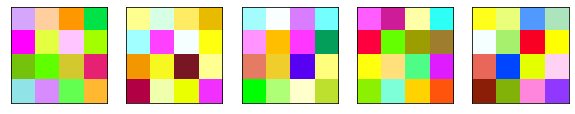

generated_images_8x8


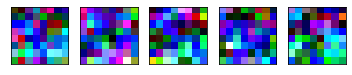

generated_images_16x16


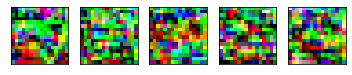

generated_images_32x32


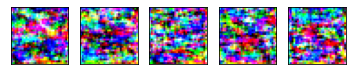

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for k, v in sorted_generated_images:
    print(k)
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(v[i], cmap=plt.cm.binary)
    plt.show()

#### Adam

In [110]:
!ls trained_model/export/exporter | tail -1

1591421247


In [111]:
predict_fn = tf.contrib.predictor.from_saved_model(
    "trained_model/export/exporter/1591421247"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

INFO:tensorflow:Restoring parameters from trained_model/export/exporter/1591421247/variables/variables


Convert image back to the original scale.

In [112]:
generated_images = {
    k: np.clip(
        a=((v + 1.0) * (255. / 2)).astype(np.int32),
        a_min=0,
        a_max=255
    )
    for k, v in predictions.items()
}

sorted_generated_images = [
    x[0:2]
    for x in sorted(
        [
            (
                k,
                generated_images[k],
                generated_images[k].shape[-2]
            )
            for k in generated_images.keys()
        ],
        key=lambda tup: tup[2]
    )
]

for k, v in sorted_generated_images:
    print(k, v.shape)

generated_images_4x4 (500, 4, 4, 3)
generated_images_8x8 (500, 8, 8, 3)
generated_images_16x16 (500, 16, 16, 3)
generated_images_32x32 (500, 32, 32, 3)


generated_images_4x4


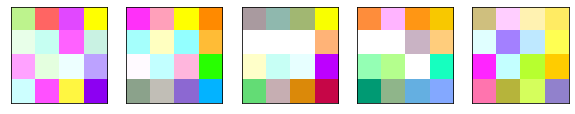

generated_images_8x8


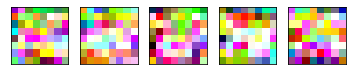

generated_images_16x16


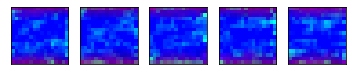

generated_images_32x32


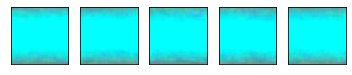

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for k, v in sorted_generated_images:
    print(k)
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(v[i], cmap=plt.cm.binary)
    plt.show()